# 京东充电宝 Top-50 评论数据分析

## HanLP+人工列举差评关键词

In [ ]:
import numpy as np
import pandas as pd
import hanlp
from collections import Counter
import re
import matplotlib.pyplot as plt

In [2]:
# =============================
# 1️ 读取 CSV
# =============================
df = pd.read_csv("../data/jd_reviews_all.csv")

print(f"读取完成：共有 {len(df)} 行")

读取完成：共有 50 行


In [3]:
# =============================
# 2️ 加载轻量单任务分词模型
# =============================
# # Show available pretrained tokenizers
# # 查看可用的预训练分词器
# hanlp.pretrained.tok.ALL 
tokenizer = hanlp.load(hanlp.pretrained.tok.FINE_ELECTRA_SMALL_ZH)

print("HanLP分词模型加载完成：FINE_ELECTRA_SMALL_ZH")

# =============================
# 3️ 所有差评分词汇总
# =============================
all_tokens = []

for idx, row in df.iterrows():
    for i in range(1, 6):
        review = row.get(f'negative_review_{i}', '')
        if isinstance(review, str) and review.strip():
            tokens = tokenizer(review)
            all_tokens.extend(tokens)

print(f"共分词数量：{len(all_tokens)}")

HanLP分词模型加载完成：FINE_ELECTRA_SMALL_ZH
共分词数量：2806


In [4]:
# =============================
# 4️ 加载停用词表
# =============================
stopwords_name = "baidu"  # 可选："baidu", "hit", "scu"
stopwords = set()
with open(f'../data/{stopwords_name}_stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = set(line.strip() for line in f if line.strip())

print(f"加载停用词表完成，共 {len(stopwords)} 个停用词")

# =============================
# 5️ 去停用词 + 可选：去除单字词
# =============================
punctuations = set("，。！？、；：”“‘’（）【】《》—…￥·~")
filtered_tokens = [w for w in all_tokens if w not in stopwords and w not in punctuations]
filtered_tokens2 = [w for w in filtered_tokens if len(w) > 1]
single_tokens = [w for w in filtered_tokens if len(w) == 1]

print(f"过滤后剩余词数：{len(filtered_tokens2)}")

加载停用词表完成，共 1395 个停用词
过滤后剩余词数：875


In [5]:
# =============================
# 6️ 统计词频
# =============================
freq = Counter(filtered_tokens2)

# 打印前 50 个长度大于 1 的高频词
print("Top 50 高频词（长度 > 1）：")
for word, count in freq.most_common(50):
    print(f"{word}: {count}")

Top 50 高频词（长度 > 1）：
充电: 54
评价: 20
用户: 19
填写: 19
内容: 19
手机: 19
充电宝: 15
容量: 14
降价: 13
客服: 10
苹果: 8
质量: 8
小时: 7
保护: 7
华为: 7
东西: 6
收到: 6
数据线: 6
价格: 6
接口: 6
电量: 6
快递: 5
第一: 5
包装: 5
20: 5
支持: 5
小米: 5
虚标: 5
京东: 5
不错: 4
连接: 4
告知: 4
12: 4
送来: 4
功率: 4
发烫: 4
产品: 4
真的: 4
别人: 4
接触: 4
10: 4
发现: 3
说好: 3
打开: 3
充满: 3
没用: 3
物流: 3
速度: 3
原配: 3
居然: 3


In [6]:
freq_single = Counter(single_tokens)

# 打印前 50 个高频单字
print("Top 50 高频单字（长度 = 1）：")
for word, count in freq_single.most_common(50):
    print(f"{word}: {count}")

Top 50 高频单字（长度 = 1）：
不: 110
充: 46
买: 42
没: 36
电: 30
天: 26
次: 26
还: 22
未: 19
说: 16
好: 15
很: 15
都: 14
坏: 14
两: 14
慢: 13
线: 12
快: 12
刚: 9
上: 9
货: 9
会: 9
差: 8
月: 8
小: 7
后: 7
热: 6
才: 6
行: 6
只: 5
满: 5
大: 5
中: 4
动: 4
里: 4
贵: 4
太: 4
真: 4
钱: 4
越: 4
高: 3
花: 3
掉: 3
想: 3
三: 3
进: 3
早: 3
降: 3
带: 3
换: 3


In [7]:
# # =============================
# # 7️ 保存词频表到 CSV
# # =============================
# df_freq = pd.DataFrame(freq.most_common(), columns=["word", "count"])
# df_freq.to_csv(f"word_frequency_{stopwords_name}.csv", index=False, encoding="utf-8-sig")

# print("已保存到 word_frequency.csv")

根据高频词，我们可以设计一个【核心标签 + 模糊匹配正则】的字典，用于后续对评论做标签匹配。

In [8]:
# =============================
# 8 设计核心标签 + 模糊匹配正则字典
# =============================
bad_keywords = {
    # 充电慢 / 充不满
    '充电慢': [
        r'充.*慢',
        r'充满.*久',
        r'充不满',
        r'充电宝.*慢',
        r'速度.*慢',
        r'龟速'
    ],

    # 虚标容量 / 容量小
    '容量虚标': [
        r'容量.*虚标',
        r'容量.*小',
        r'虚标',
        r'电量.*虚标',
        r'电量.*不够'
    ],

    # 发热 / 发烫
    '发热': [
        r'发热',
        r'发烫',
        r'烫手',
        r'很烫'
    ],

    # 质量问题
    '质量差': [
        r'质量.*差',
        r'坏了',
        r'坏掉',
        r'坏死',
        r'没用',
        r'用不了',
        r'用坏了'
    ],

    # 客服态度差 / 售后不好
    '客服差': [
        r'客服.*差',
        r'客服.*不理',
        r'客服.*不行',
        r'售后.*差',
        r'售后.*不理',
        r'告知.*不理',
        r'态度.*差'
    ],

    # 物流慢 / 包装问题
    '物流慢': [
        r'快递.*慢',
        r'物流.*慢',
        r'送来.*慢',
        r'包装.*破',
        r'包装.*烂'
    ],

    # 价格降价 / 买贵
    '价格问题': [
        r'降价',
        r'价格.*高',
        r'买贵',
        r'比别家贵'
    ],

    # 接口/数据线问题
    '接口问题': [
        r'接口.*松',
        r'接口.*坏',
        r'数据线.*坏',
        r'连接.*不稳',
        r'接触.*不良'
    ]
}


## 生成核心指标

虽然我们已经有每个商品的好评率了，但是单凭这个无法计算每个店铺的好评率。所以我们需要通过好评数、中评数以及差评数手动计算好评率，方便后续进行店铺间的比较。

In [9]:
# =============================
# 计算总评论数 & 自算好评率
# =============================
df["total_reviews"] = df[["positive_count", "neutral_count", "negative_count"]].sum(axis=1)
df["positive_rate_calc"] = df["positive_count"] / df["total_reviews"]

# 快速 sanity-check
df[["positive_rate", "positive_rate_calc"]].head()

,positive_rate,positive_rate_calc
0,97%,0.966184
1,98%,0.980392
2,97%,0.980392
3,98%,0.980392
4,98%,0.965437


可以看到“手算”的好评率和京东上显示的好评率有些许区别。不过考虑到京东上提供的好/中/差评数并不精确，目前这些差别总得看起来还是能接受的。不过个别商品的出入还是有点大。

## 差评「标签化」

In [10]:
# =============================
# 把每条差评打上多标签，统计频次
# =============================
def extract_tags(text, pattern_dict):
    tags = []
    for tag, patterns in pattern_dict.items():
        if any(re.search(pat, text) for pat in patterns):
            tags.append(tag)
    return tags

# 循环所有 negative_review_1-5，生成多行记录
records = []
for _, row in df.iterrows():
    for i in range(1, 6):
        txt = row.get(f'negative_review_{i}', '')
        if isinstance(txt, str) and txt.strip():
            tags = extract_tags(txt, bad_keywords)
            records.append({
                "SKU": row["SKU"],
                "store": row["store"],
                "review_txt": txt,
                "tags": tags
            })

neg_tag_df = pd.DataFrame(records)
neg_tag_df.head(20)

,SKU,store,review_txt,tags
0,100024102298,罗马仕京东自营旗舰店,此用户未填写评价内容,[]
1,100024102298,罗马仕京东自营旗舰店,此用户未及时填写评价内容,[]
2,100024102298,罗马仕京东自营旗舰店,此用户未及时填写评价内容,[]
3,100024102298,罗马仕京东自营旗舰店,此用户未填写评价内容,[]
4,100024102298,罗马仕京东自营旗舰店,此用户未及时填写评价内容,[]
5,100096418777,小米京东自营旗舰店,充电过程中插头过热烫手,[发热]
6,100096418777,小米京东自营旗舰店,刚买了几天就发现降价了，体验感不好,[价格问题]
7,100096418777,小米京东自营旗舰店,此用户未填写评价内容,[]
8,100096418777,小米京东自营旗舰店,容量很一般，性价比不高！,[]
9,100096418777,小米京东自营旗舰店,嗯，那个壳被压的稀烂了，还是有点小,[]


差评高频词的匹配率看起来还可以接受，所以我们将继续使用目前的标签匹配字典。如果想进一步提高匹配率的话可以对每个标签加入更多模糊匹配正则。

In [11]:
# 每个差评可能有多个标签，使用 explode 展开
exploded = neg_tag_df.explode("tags").dropna(subset=["tags"])

## 生成各级别汇总表

| 表 | 用途 |
| - | - |
| `store_rate_df` | 店铺级好评率排行榜 |
| `sku_rate_df` | 商品级好评率排行 |
| `bubble_df` | 评论量 vs. 好评率 |
| `tag_freq_low`, `tag_freq_high` | 差评关键词对比 |
| `heatmap_df` | 关键词 $\times$ 店铺频次热力图 |


In [12]:
# ---------- 店铺级汇总 ----------
store_rate_df = (
    df.groupby("store", as_index=False)
    .agg({"positive_count": "sum", "neutral_count": "sum", "negative_count": "sum"})
    .assign(
        total_reviews=lambda d: d[
            ["positive_count", "neutral_count", "negative_count"]
        ].sum(axis=1),
        store_rate=lambda d: d["positive_count"] / d["total_reviews"],
    )
    .sort_values("store_rate", ascending=False)
)
# 转化为百分数
store_rate_df['store_rate_pct'] = store_rate_df['store_rate'] * 100

# ---------- SKU 级汇总 ----------
sku_rate_df = (
    df[
        [
            "SKU",
            "product_name",
            "store",
            "positive_count",
            "neutral_count",
            "negative_count",
            "total_reviews",
            "positive_rate_calc",
        ]
    ]
    .sort_values("positive_rate_calc", ascending=False)
    .reset_index(drop=True)
)
# 转化为百分数
sku_rate_df['positive_rate_pct'] = sku_rate_df['positive_rate_calc'] * 100

# ---------- 评论量-满意度气泡图数据 ----------
# 直接复用 store_rate_df
bubble_df = store_rate_df
# # 或者更改列名
# bubble_df = store_rate_df.rename(columns={"store_rate": "positive_rate"})

# ---------- 差评关键词频次：高分 vs 低分 ----------
# 先取 Top-N / Bottom-N SKU
top_n, bottom_n = 10, 10
top_skus = sku_rate_df.head(top_n).copy()
bottom_skus = sku_rate_df.tail(bottom_n).copy()


def tag_freq(sku_list):
    return (
        exploded[exploded["SKU"].isin(sku_list)]
        .groupby("tags")
        .size()
        .sort_values(ascending=False)
        .reset_index(name="freq")
    )


tag_freq_high = tag_freq(top_skus["SKU"])  # 高好评 SKU 的差评关键词
tag_freq_low = tag_freq(bottom_skus["SKU"])  # 低好评 SKU 的差评关键词

# ---------- 关键词 × 店铺热力图 ----------
heatmap_df = (
    exploded.groupby(["store", "tags"])
    .size()
    .unstack(fill_value=0)  # 行 = store, 列 = tag
)

# # ---------- 店铺内部离群值速查 ----------
# # 计算每店铺内各 SKU 距店平均好评率的偏差
# sku_rate_df["store_avg_rate"] = sku_rate_df.groupby("store")["positive_rate_calc"].transform("mean")
# sku_rate_df["rate_delta"] = sku_rate_df["positive_rate_calc"] - sku_rate_df["store_avg_rate"]

## 可视化 & 分析

In [13]:
plt.rcParams['font.sans-serif']=['SimHei']

### 店铺好评排行榜

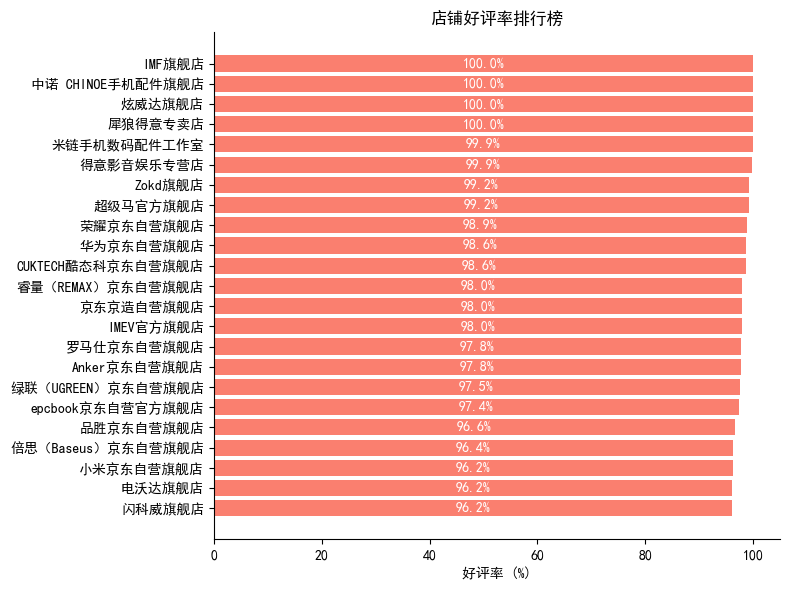

In [14]:
# =============================
#  店铺好评率水平条形图
# =============================
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.barh(store_rate_df['store'], store_rate_df['store_rate_pct'], color='#FA7F6F')
ax.invert_yaxis()  # 反转 Y 轴，使得好评率高的店铺在上方

# 添加百分比标签
ax.bar_label(
    bars,
    fmt='%.1f%%',
    label_type='center',
    color='white',
    fontsize=10
)

# 设置图表属性
ax.set_xlabel('好评率 (%)')
ax.set_title('店铺好评率排行榜')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

注意到前几家店铺的好评率非常高，甚至有四家达到了100%的好评率，这并不符合常理。需要用评论量检视是否样本过小。

In [15]:
# 取好评率最高的前10家店铺，并查看它们的评论总量
n_stores = 10
top_stores = (
    store_rate_df
      .sort_values('store_rate', ascending=False)   # 好评率降序
      .head(n_stores)                                      # 前 N 行
      [['store', 'total_reviews', 'store_rate']]    # 挑选想看的列
)
top_stores

,store,total_reviews,store_rate
3,IMF旗舰店,2000,1.000000
6,中诺 CHINOE手机配件旗舰店,500,1.000000
13,炫威达旗舰店,2000,1.000000
14,犀狼得意专卖店,200,1.000000
17,米链手机数码配件工作室,1001,0.999001
12,得意影音娱乐专营店,2003,0.998502
4,Zokd旗舰店,10084,0.991670
21,超级马官方旗舰店,20170,0.991572
20,荣耀京东自营旗舰店,10111,0.989022
9,华为京东自营旗舰店,50700,0.986193


前几名店铺的总评论数量大都在2000左右或者更低，对应的好频率的可信度也并不高。其中【中诺 CHINOE手机配件旗舰店】和【犀狼得意专卖店】的总评论量甚至只有几百。而【IMF旗舰店】和【炫威达旗舰店】虽然有2000的总评论数，但是100%的好评率有可能是通过删差评得到的，需要后续检查。【米链手机数码配件工作室】和【得意影音娱乐专营店】也有同样的嫌疑。

相比之下，从第七名【Zokd旗舰店】开始，后续的总评论数都大于1万，也更可信。

### 评论量 vs. 好评率（店铺层面）

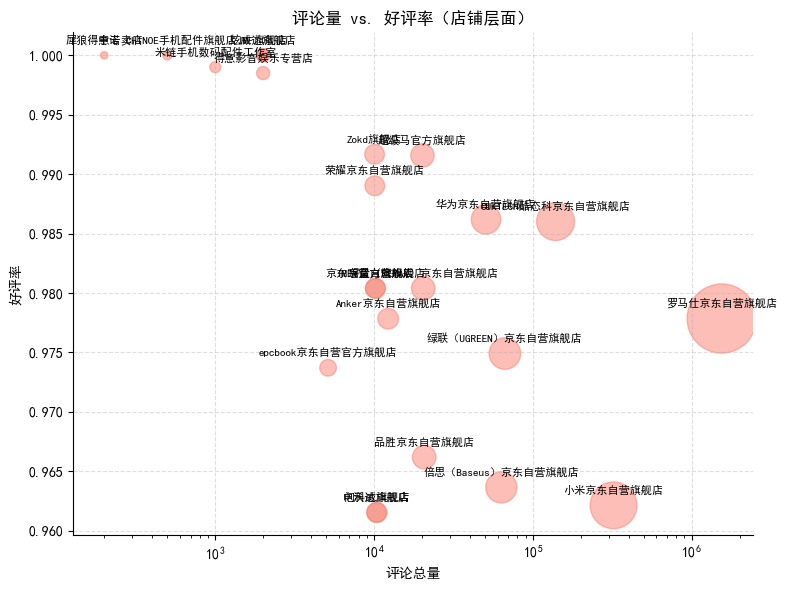

In [16]:
# =============================
#  评论量-满意度气泡图
# =============================
plt.figure(figsize=(8, 6))
sizes = np.sqrt(bubble_df['total_reviews']) * 2  # 气泡大小
plt.scatter(bubble_df['total_reviews'],
            bubble_df['store_rate'],
            s=sizes, 
            color='#FA7F6F', 
            alpha=0.5)

# 添加每个点的标签
for _, row in bubble_df.iterrows():
    plt.text(
        row['total_reviews'],
        row['store_rate'] + 0.001,  # Y 方向微调
        row['store'],
        fontsize=8,
        ha='center'
    )

# 设置图表属性
plt.xscale('log')
plt.xlabel('评论总量')
plt.ylabel('好评率')
plt.title('评论量 vs. 好评率（店铺层面）')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(ls='--', alpha=0.4)
plt.tight_layout()
plt.show()


从气泡图中，可以得出与好评率排行榜相似的结论：
- 店铺好评榜的前六名并不可信：虽然好频率100%（或接近100%），但是总评论量低，统计意义有限。可能存在样本偏差或差评被过滤的情况。
- 店铺好评榜从第七名开始，以【Zokd旗舰店】为为代表的店铺同时兼顾高好评率与较大评论量，结果更可靠。
- 【罗马仕京东自营旗舰店】的总评论量遥遥领先。其好评率虽仍在可接受区间，却明显低于行业头部。相比之下，【小米京东自营旗舰店】和【倍思（Baseus）京东自营旗舰店】的总评论数虽稍低，但是好评率却远低于大部分其他店铺，值得重点关注其差评原因。

### 商品 Top-10 & Bottom-10 好评率

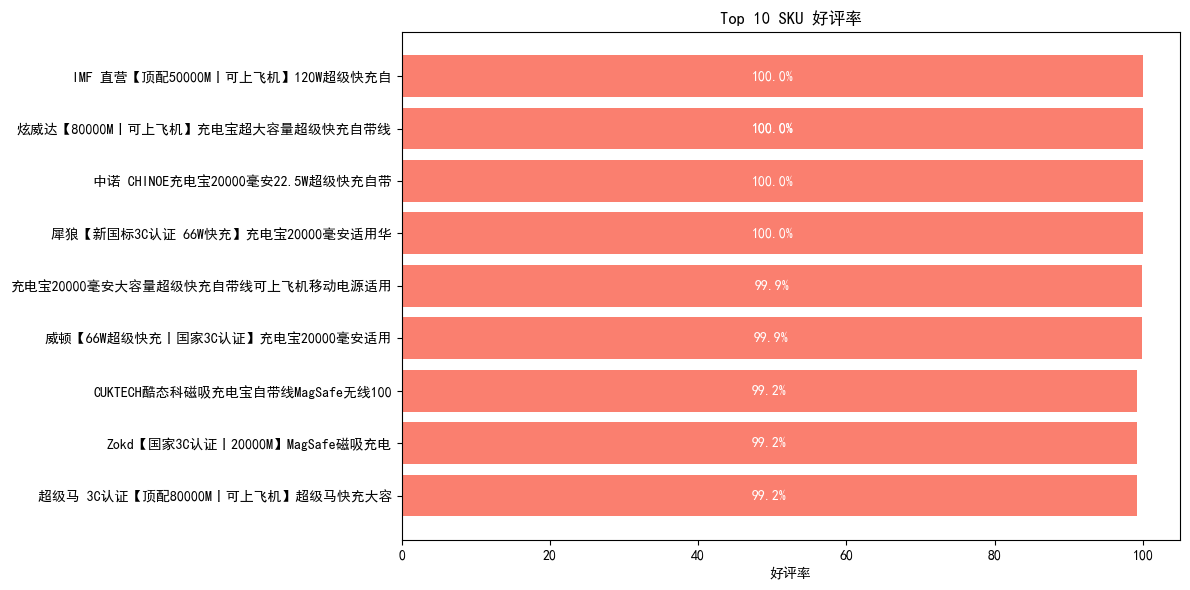

In [17]:
# =============================
#  SKU Top-10 & Bottom-10 好评率条形图
# =============================

# 商品名只显示前m个字符
m = 30
top_skus.loc[:, 'short_name'] = top_skus['product_name'].str[:m]
bottom_skus.loc[:, 'short_name'] = bottom_skus['product_name'].str[:m]

# 绘制 Top-10 和 Bottom-10 SKU 好评率的水平条形图
# --- Top 10 ---
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_skus['short_name'], top_skus['positive_rate_pct'], color='#FA7F6F')
ax.invert_yaxis()
ax.bar_label(
    bars,
    fmt='%.1f%%',
    label_type='center',
    color='white',
    fontsize=10
)
ax.set_title('Top 10 SKU 好评率')
ax.set_xlabel('好评率')
plt.tight_layout()
plt.show()

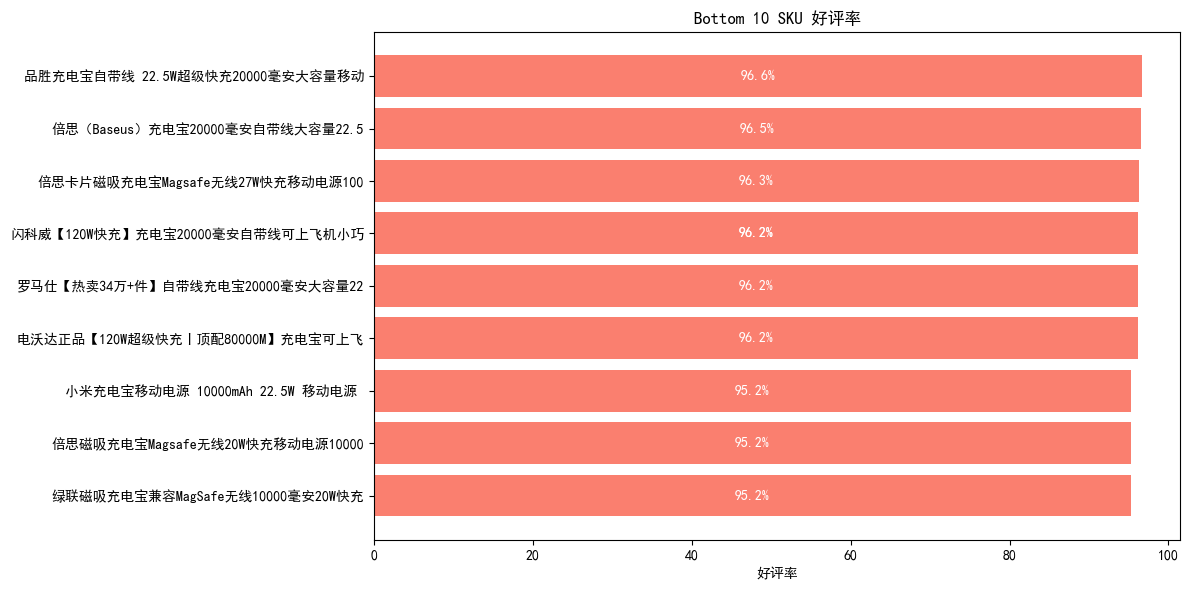

In [18]:
# --- Bottom 10 ---
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(bottom_skus['short_name'], bottom_skus['positive_rate_pct'], color='#FA7F6F')
ax.invert_yaxis()
ax.bar_label(
    bars,
    fmt='%.1f%%',
    label_type='center',
    color='white',
    fontsize=10
)
ax.set_title('Bottom 10 SKU 好评率')
ax.set_xlabel('好评率')
plt.tight_layout()
plt.show()

商品层面的排行耪与之前的结论一致：
- 小体量品牌更易出现高好评率
- 大体量品牌更容易被挑剔

### 差评关键词对比（低分 vs 高分）

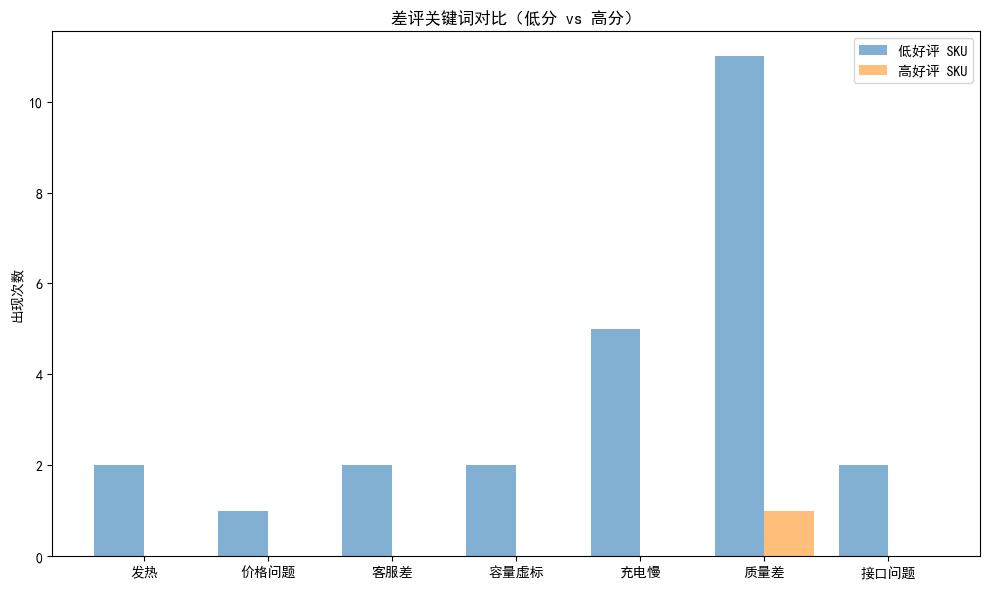

In [19]:
# =============================
#  差评关键词频次并列条形图
# =============================

# 取并集（注意转 list 保证可重复索引）
all_tags = list(set(tag_freq_low['tags']).union(set(tag_freq_high['tags'])))

# 用 tags 做索引后 reindex
low_vals  = tag_freq_low.set_index('tags').reindex(all_tags)['freq'].fillna(0)
high_vals = tag_freq_high.set_index('tags').reindex(all_tags)['freq'].fillna(0)

x = np.arange(len(all_tags))  # x 轴位置
bar_width = 0.4

plt.figure(figsize=(10, 6))

# 左右错开，保证并列
plt.bar(x - bar_width/2, low_vals, bar_width, label='低好评 SKU', color='#82B0D2')
plt.bar(x + bar_width/2, high_vals, bar_width, label='高好评 SKU', color='#FFBE7A')

plt.xticks(x, all_tags)
plt.ylabel('出现次数')
plt.title('差评关键词对比（低分 vs 高分）')
plt.legend()
plt.tight_layout()
plt.show()

低评分商品差评关键词分布：
- 质量相关占比远高于其他，说明产品可靠性需要做为首要改进点。

- 性能兑现（充电慢 + 容量虚标）也占了很多比重，说明规格与体验落差也显著影响口碑。
    - 建议：实测功率 / 容量数据写入详情页，必要时升级快充方案。

- 服务相关差评虽占比不高，但也需重视。
    - 建议：对于出现服务问题的店铺针对性补强客服培训。

高评分商品差评关键词几乎无高频痛点，仅出现1次“质量差”，提示这一问题在高分组不具代表性。

### 关键词 $\times$ 店铺热力图

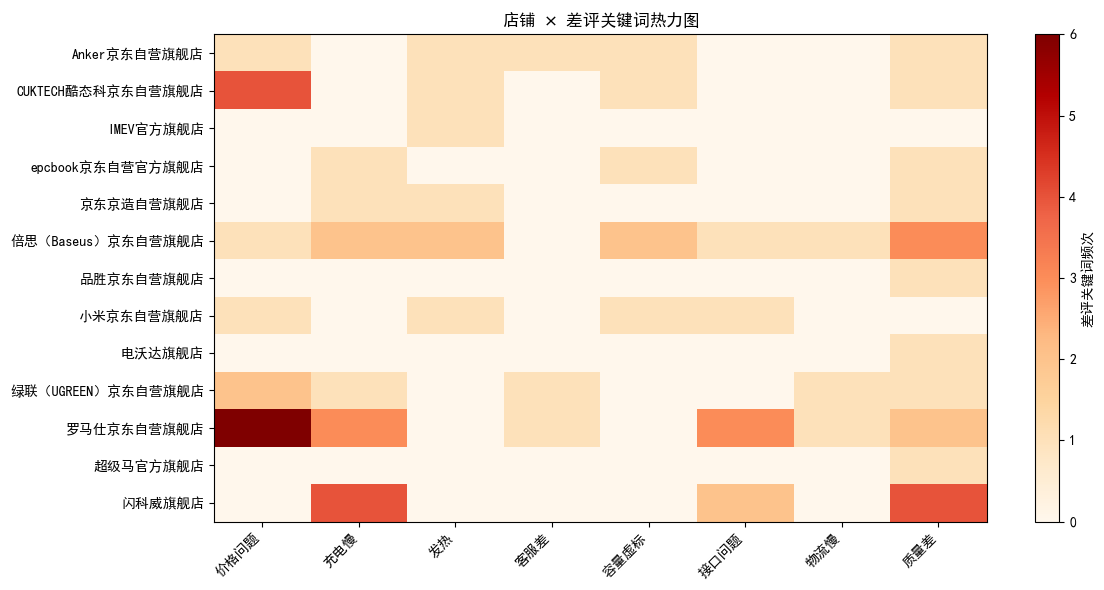

In [20]:
# =============================
#  差评关键词-店铺热力图
# =============================
plt.figure(figsize=(12, 6))

# 将 DataFrame 转成矩阵，行列标签记录下来
mat = heatmap_df.values
stores = heatmap_df.index.tolist()
tags   = heatmap_df.columns.tolist()

plt.imshow(mat, aspect='auto', interpolation='nearest', cmap='OrRd')
plt.colorbar(label='差评关键词频次')

plt.xticks(range(len(tags)), tags, rotation=45, ha='right')
plt.yticks(range(len(stores)), stores)
plt.title(r'店铺 $\times$ 差评关键词热力图')
plt.tight_layout()
plt.show()


重点店铺诊断：

* **罗马仕京东自营旗舰店**
  * 主要痛点：价格问题、充电慢、接口问题。还有轻微客服差、物流慢、质量差。
  * 建议：
    1. **充电慢 & 接口**：升级快充方案、提高端子耐久测试标准
    2. **价格问题**：推出会员价／满减券，明确促销节奏防止价格跳水

* **小米京东自营旗舰店**
  * 主要痛点：常见关键词提及不多，但整体好评率偏低，推测痛点分散或隐藏在细节
  * 建议：
    1. 深度分析差评找出隐性问题
    2. 对反馈集中的商品做小批次改进并跟踪评分变化

* **倍思（Baseus）京东自营旗舰店**
  * 主要痛点：除了客服差其余全覆盖。各类差评分布平均，质量相关略多
  * 建议：
    1. **质量**：针对做工、外壳、焊点等“质量差”子项加强抽检
    2. **容量 & 发热**：在详情页公开容量／功率实测值，减少预期落差

* **闪科威旗舰店**
  * 主要痛点：质量差、充电慢、接口问题集中
  * 建议：
    1. **质量**：针对做工、外壳、焊点等“质量差”子项加强抽检
    2. **充电慢 & 接口**：升级快充方案、提高端子耐久测试标准